# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_curve = []
         
    def get_sigmoid(self, X, weights):
        """Calculate the sigmoid."""
        return 1 / (1 + np.exp(-(X @ weights)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        return (np.log(1 + np.exp(-y*(x @ self.weights_)))).mean() + 1/2/self.C*np.linalg.norm(weights)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        for i in range(self.max_iter):
            loss = (1- 1/(1 + np.exp(-y*(X_ext @ self.weights_))))*y
            delta = (X_ext.T @ loss) / y.shape[0] + self.weights_/self.C
            self.weights_ += self.eta * delta 
            self.loss_curve.append(self.get_loss(X_ext,self.weights_,y))
            if np.linalg.norm(self.eta * delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        y = np.zeros(X_ext.shape[0])
        y[self.get_sigmoid(X_ext, self.weights_) >= 0.5] = 1
        y[self.get_sigmoid(X_ext, self.weights_) < 0.5] = -1
        return y

In [5]:
from sklearn import datasets
from sklearn import metrics

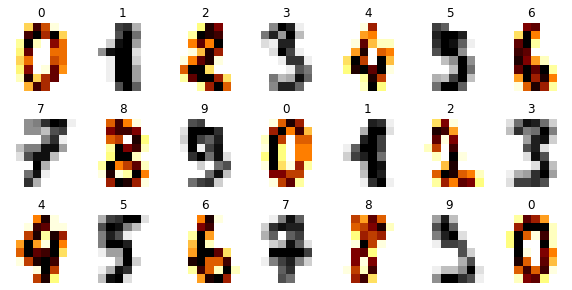

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

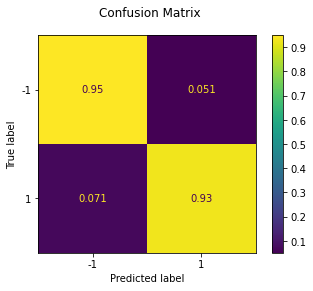

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9157967988865693, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

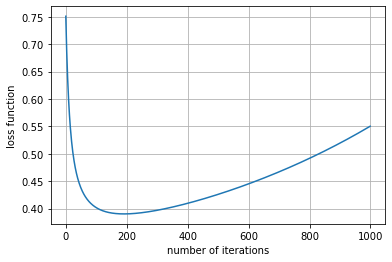

In [17]:
plt.plot(range(len(model.loss_curve)),model.loss_curve)
plt.xlabel('number of iterations')
plt.ylabel('loss function')
plt.grid(True)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

<ipython-input-4-c14be1ed864d>:36: RuntimeWarning: overflow encountered in exp
  return (np.log(1 + np.exp(-y*(x @ self.weights_)))).mean() + 1/2/self.C*np.linalg.norm(weights)
<ipython-input-4-c14be1ed864d>:55: RuntimeWarning: overflow encountered in exp
  loss = (1- 1/(1 + np.exp(-y*(X_ext @ self.weights_))))*y


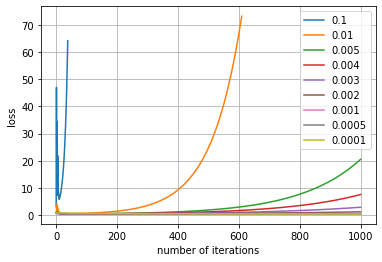

In [18]:
for eta in [0.1,0.01,0.005,0.004,0.003,0.002,0.001,0.0005,0.0001]:
    model = CustomLogisticRegression(eta = eta)
    model.fit(X_train,y_train)
    plt.plot(range(len(model.loss_curve)),model.loss_curve,label=f'{eta}')
    plt.xlabel('number of iterations')
    plt.ylabel('loss function')
    plt.ylabel(f'loss')
    plt.legend(loc='upper right')
    plt.grid(True)

 Let's take a closer look

<ipython-input-4-c14be1ed864d>:36: RuntimeWarning: overflow encountered in exp
  return (np.log(1 + np.exp(-y*(x @ self.weights_)))).mean() + 1/2/self.C*np.linalg.norm(weights)
<ipython-input-4-c14be1ed864d>:55: RuntimeWarning: overflow encountered in exp
  loss = (1- 1/(1 + np.exp(-y*(X_ext @ self.weights_))))*y


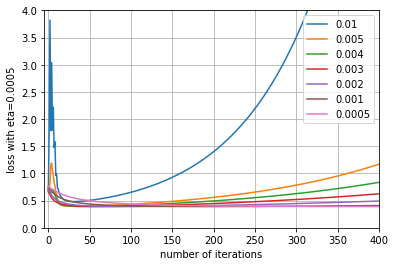

In [19]:
for eta in [0.01,0.005,0.004,0.003,0.002,0.001,0.0005]:
    model = CustomLogisticRegression(eta = eta,max_iter=3000)
    model.fit(X_train,y_train)
    plt.plot(range(len(model.loss_curve)),model.loss_curve,label=f'{eta}')
    plt.xlabel('number of iterations')
    plt.ylabel('loss function')
    plt.ylabel(f'loss with eta={eta}')
    plt.legend(loc='upper right')
    plt.xlim(-5,400)
    plt.ylim(0,4)
    plt.grid(True)

We can see that `eta` = 0.01 is way too high, values from 0.005 to 0.003 are also too high since the loss function keeps growing instead of minimazing.

Let's examine loss functions with `eta` from 0.002 and lower, since the plot is kinf of messy in that area.

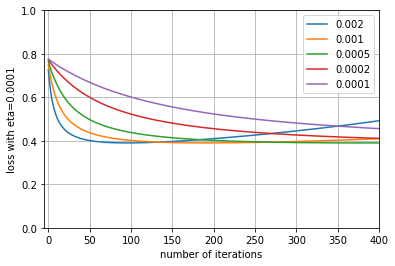

In [20]:
for eta in [0.002,0.001,0.0005,0.0002,0.0001]:
    model = CustomLogisticRegression(eta = eta,max_iter=3000)
    model.fit(X_train,y_train)
    plt.plot(range(len(model.loss_curve)),model.loss_curve,label=f'{eta}')
    plt.xlabel('number of iterations')
    plt.ylabel('loss function')
    plt.ylabel(f'loss with eta={eta}')
    plt.legend(loc='upper right')
    plt.xlim(-5,400)
    plt.ylim(0,1)
    plt.grid(True)

I would consider learning rates 0.0001 and 0.0002 too low, gradient descent at such rate would be too slow.

`eta` = 0.002 seems a little to high if we take a closer look.

We are left with `eta` equal 0.001 and 0.0005, out of these two I would consider 0.001 a little better as it converges faster

**(0.5 points)** Try different regularization parameter values and compare the model quality.

<ipython-input-4-c14be1ed864d>:36: RuntimeWarning: overflow encountered in exp
  return (np.log(1 + np.exp(-y*(x @ self.weights_)))).mean() + 1/2/self.C*np.linalg.norm(weights)
<ipython-input-4-c14be1ed864d>:55: RuntimeWarning: overflow encountered in exp
  loss = (1- 1/(1 + np.exp(-y*(X_ext @ self.weights_))))*y


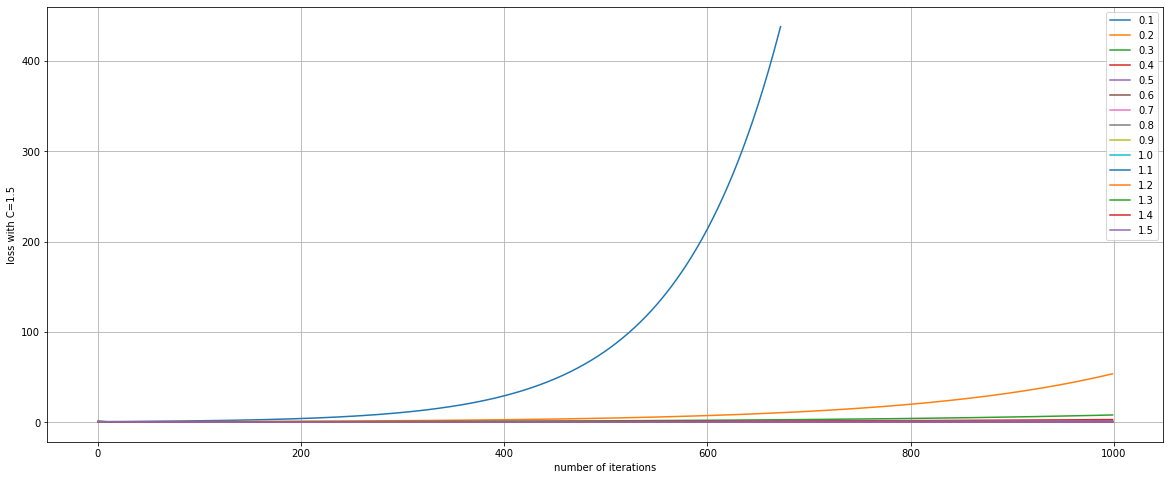

In [21]:
C_values = np.linspace(0.1,1.5,15)
plt.rcParams['figure.figsize'] = (20,8)
for C in C_values:
    model = CustomLogisticRegression(C=C)
    model.fit(X_train,y_train)
    plt.plot(range(len(model.loss_curve)),model.loss_curve,label=f'{round(C,1)}')
    plt.xlabel('number of iterations')
    plt.ylabel('loss function')
    plt.ylabel(f'loss with C={C}')
    plt.legend(loc='upper right')
    #plt.xlim(-5,400)
    #plt.ylim(0,1)
    plt.grid(True)

`C` equal to 0.1 or 0.2 is way too high. Let's examine higher `C` values.

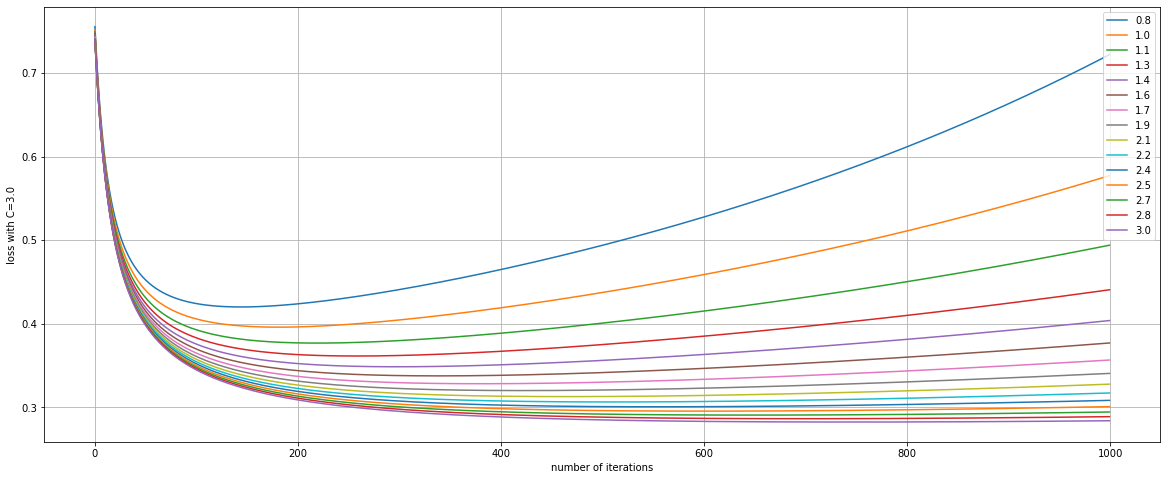

In [22]:
C_values = np.linspace(0.8,3,15)
for C in C_values:
    model = CustomLogisticRegression(C=C)
    model.fit(X_train,y_train)
    plt.plot(range(len(model.loss_curve)),model.loss_curve,label=f'{round(C,1)}')
    plt.xlabel('number of iterations')
    plt.ylabel('loss function')
    plt.ylabel(f'loss with C={C}')
    plt.legend(loc='upper right')
    #plt.xlim(-5,400)
    #plt.ylim(0,1)
    plt.grid(True)

Looking at this plot, I would say the higher the `C` is the better.

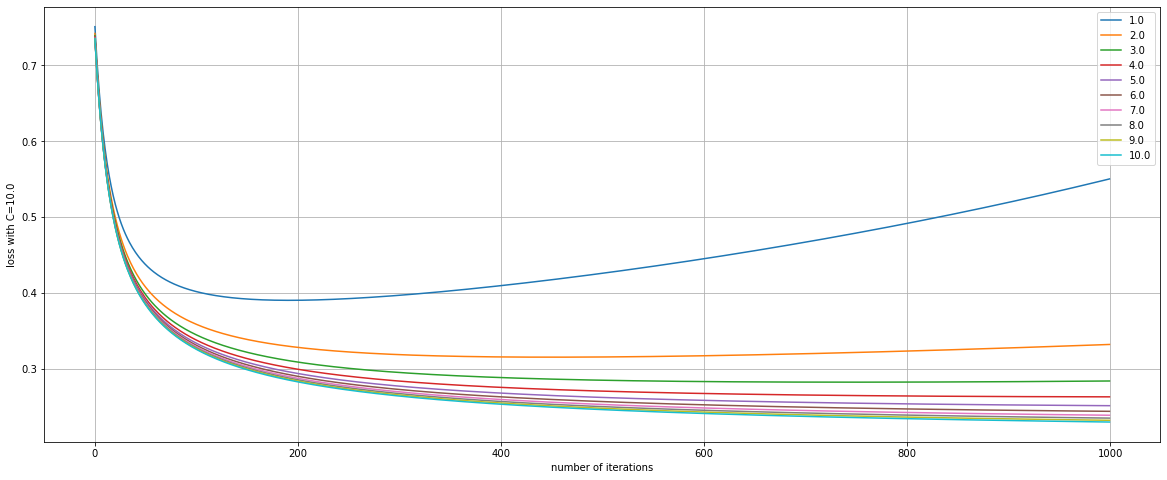

In [23]:
C_values = np.linspace(1,10,10)
for C in C_values:
    model = CustomLogisticRegression(C=C)
    model.fit(X_train,y_train)
    plt.plot(range(len(model.loss_curve)),model.loss_curve,label=f'{round(C,1)}')
    plt.xlabel('number of iterations')
    plt.ylabel('loss function')
    plt.ylabel(f'loss with C={C}')
    plt.legend(loc='upper right')
    #plt.xlim(-5,400)
    #plt.ylim(0,1)
    plt.grid(True)

I think 2 and 3 are good values.

If `C` gets higher than 5 loss function minimazing becomes too slow.

**(0.5 points)** Compare zero initialization and random initialization. 

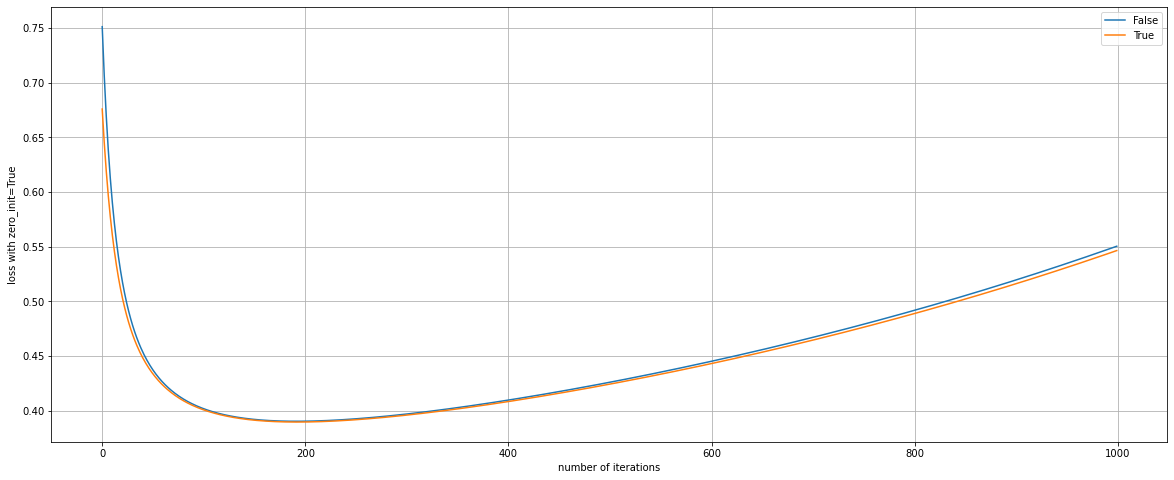

In [24]:
for init  in [False,True]:
    model = CustomLogisticRegression(zero_init=init)
    model.fit(X_train,y_train)
    plt.plot(range(len(model.loss_curve)),model.loss_curve,label=f'{init}')
    plt.xlabel('number of iterations')
    plt.ylabel('loss function')
    plt.ylabel(f'loss with zero_init={init}')
    plt.legend(loc='upper right')
    #plt.xlim(-5,400)
    #plt.ylim(0,1)
    plt.grid(True)

Zero weights initialization provides slightly lower loss function, but the difference is not significant.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [25]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9,p=2):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        self.p = p
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        p = np.zeros((X.shape[0],Y.shape[0]))
        for i in range(Y.shape[0]):
            p[:,i] = ((np.abs(X-Y[i,:]))**self.p).sum(axis=1) ** (1/self.p)
        return p
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = {}
        for cl in self.classes_:
            p[cl] = weights[np.where(y==cl)].sum()
        return np.array(list(p.values()))

            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(self.points, X)
            y = np.zeros((X.shape[0],self.classes_.shape[0]))
            if self.weights == 'distance':
                for i in range(X.shape[0]):
                    neighbours_idx = np.argpartition(P[:,i], self.n_neighbors)
                    scores = dict.fromkeys(self.classes_, 0)
                    for idx in neighbours_idx[:self.n_neighbors]:
                        scores[self.y[idx]] += 1 / (P[idx,i] + np.finfo(float).eps)       
                    y[i,:] = np.array(list(scores.values()))
                    y[i,:] = y[i,:]/y[i,:].sum()
            elif self.weights == 'uniform':
                for i in range(X.shape[0]):
                    neighbours_idx = np.argpartition(P[:,i], self.n_neighbors)
                    scores = dict.fromkeys(self.classes_, 0)
                    for idx in neighbours_idx[:self.n_neighbors]:
                        scores[self.y[idx]] += 1        
                    y[i,:] = np.array(list(scores.values()))
                    y[i,:] = y[i,:]/y[i,:].sum()
            
            return y
                    
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y = self.classes_[self.predict_proba(X).argmax(axis=1)]
        return y

In [26]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [27]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [28]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

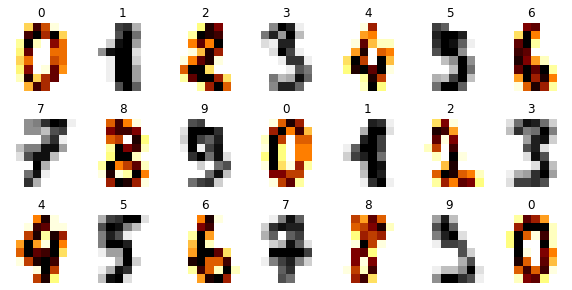

In [29]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [30]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [31]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

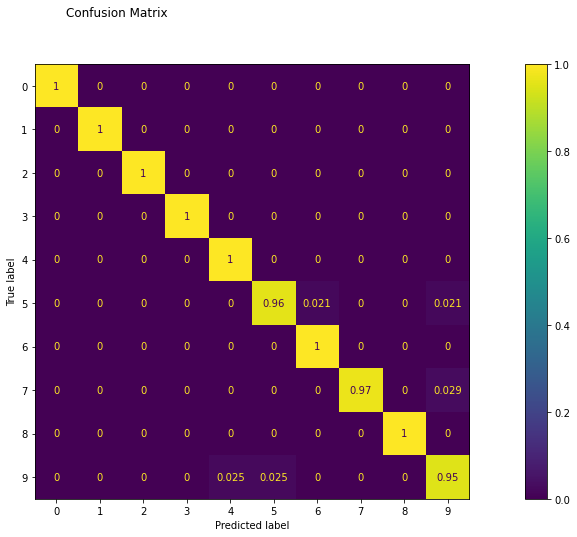

In [32]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [33]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Model predicts 6 and 9 instead of 5, because these numbers look alike, especially when handwritten. 9 also looks a little like 4 or 5, model confuses them a little.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

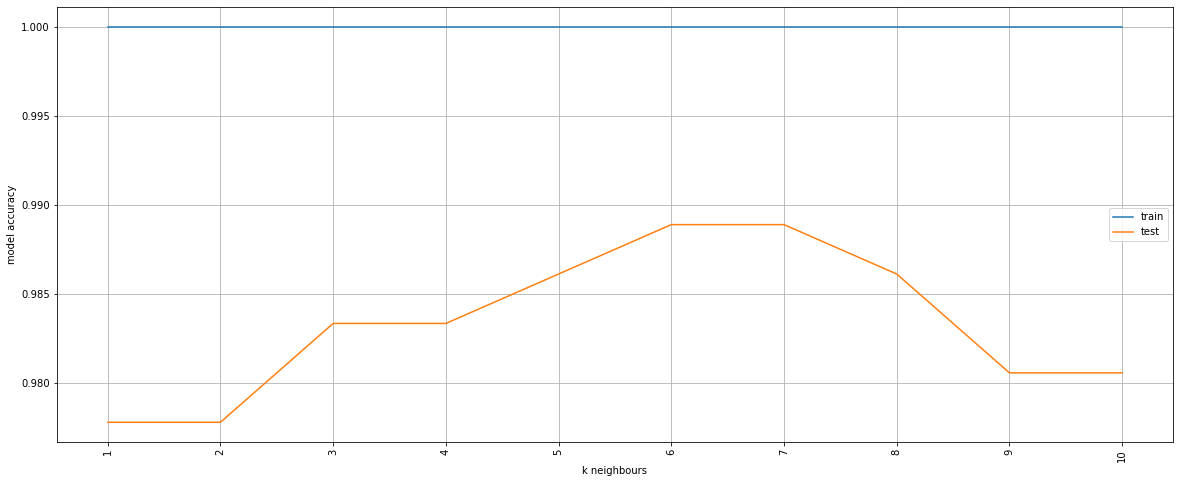

In [34]:
test_acc,train_acc = [],[]
for k  in range(1,11):
    model = CustomKNeighborsClassifier(n_neighbors=k, weights='distance')
    model.fit(X_train,y_train)
    train_acc.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    test_acc.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
plt.plot(range(1,11),train_acc,label='train')
plt.plot(range(1,11),test_acc,label='test')
plt.xlabel('k neighbours')
plt.ylabel('model accuracy')
plt.xticks(range(1,11),rotation='vertical')
plt.legend(loc='center right')
plt.grid(True)

Our model is most accurate at `n_neighbours` of 6 and 7.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

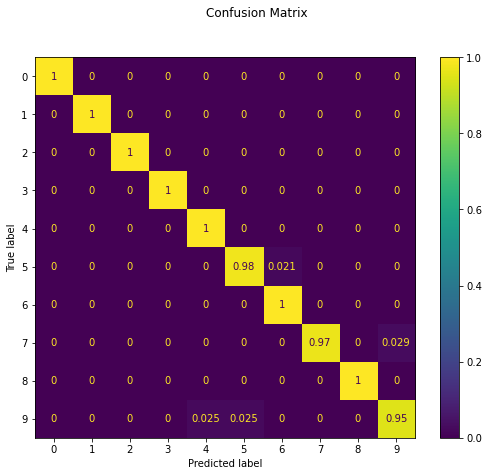

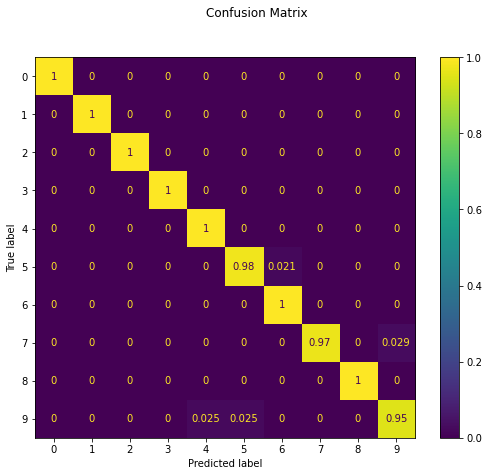

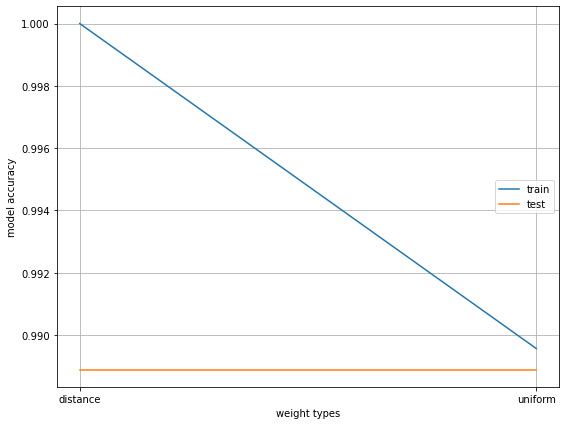

In [35]:
test_acc,train_acc = [],[]
plt.rcParams['figure.figsize'] = (9,7)
for w  in ['distance','uniform']:
    model = CustomKNeighborsClassifier(n_neighbors=6, weights=w)
    tr_acc, tst_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    train_acc.append(tr_acc)
    test_acc.append(tst_acc)
plt.plot(['distance','uniform'],train_acc,label='train')
plt.plot(['distance','uniform'],test_acc,label='test')
plt.xlabel('weight types')
plt.ylabel('model accuracy')
plt.legend(loc='center right')
plt.grid(True)

We can see that train accuracy is lower with uniform weight, but it doesn't affect test accuracy much.

Confusion matrices are exactly the same

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

COMBINED TWO ANSWERS


One could think Mathattan distance measurement wouldn't be a good choice, because our point are not situated on a grig-like plane. On the other hand, that metric is preferable when we work with high-dimensionality data to avoid *the curse of dimensionality* 

Anyway, we can use We can potentially use Minkowski distance measurment to observe how our preductions would change based on dictance measurements.

$$d\left( p,q\right)   = ({\sum _{i=1}^{n}  | q_{i}-p_{i}|^p})^{\frac{1}{p}} $$

Which gives us:
* p = 1, Manhattan Distance
* p = 2, Euclidean Distance
* p = infinity, Chebychev Distance

[Source](https://medium.com/@kunal_gohrani/different-types-of-distance-metrics-used-in-machine-learning-e9928c5e26c7)

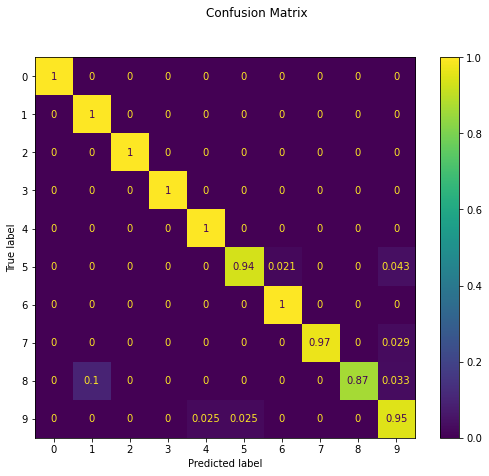

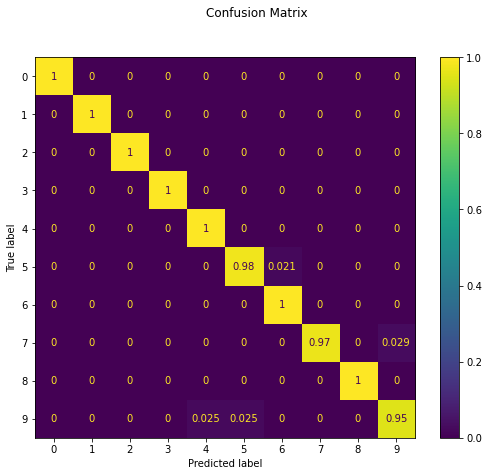

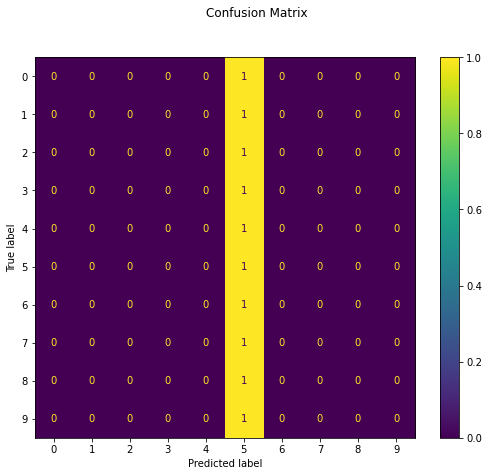

In [36]:
test_acc,train_acc = [],[]
plt.rcParams['figure.figsize'] = (9,7)
for p  in [1,2,np.inf]:
    model = CustomKNeighborsClassifier(n_neighbors=7, weights='distance',p=p)
    tr_acc, tst_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    train_acc.append(tr_acc)
    test_acc.append(tst_acc)

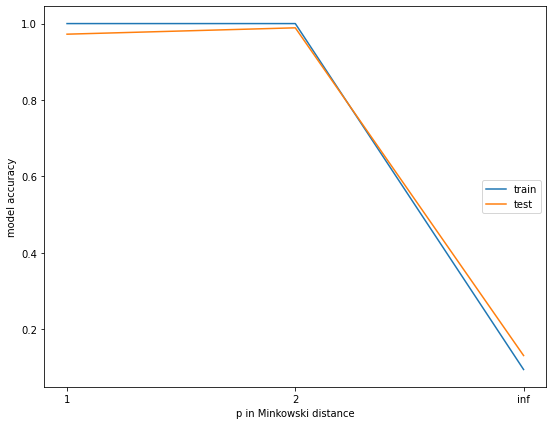

In [37]:
plt.plot(['1','2','inf'],train_acc,label='train')
plt.plot(['1','2','inf'],test_acc,label='test')
plt.xlabel('p in Minkowski distance')
plt.ylabel('model accuracy')
plt.legend(loc='center right')

We can see that Chebychev distance was not a good choice at all, and Euclidean distance did better then Mathattan, like I suspected. We don't hane high enough dimensionality for Manhattan to be more suitable metric.

#### Other distance measurements

* Cosine distance - indicates similarity beetween vectors
* Hamming distance - measures the distance between categorical values

These are not really suitable for our classification problem.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [38]:
data = pd.read_csv('train.csv').set_index('PassengerId')

In [39]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

There were 56114 men (56.11%) and 43886 women (43.89%)


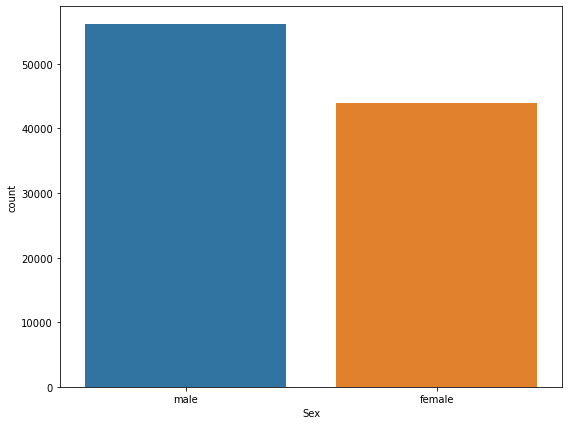

In [40]:
sns.countplot(x=data['Sex'])
men  = data[data['Sex'] == 'male'].shape[0]
women = data[data['Sex'] == 'female'].shape[0]
print(f'There were {men} men ({round(men/data.shape[0]*100,2)}%) and {women} women ({round(women/data.shape[0]*100,2)}%)')

20.58% of men survived, 71.15% of women survived


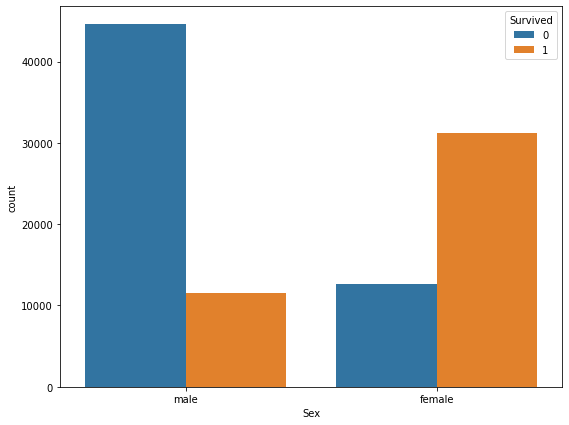

In [41]:
sns.countplot(x=data['Sex'],hue=data['Survived'])
men_survived  = data[(data['Sex'] == 'male') & (data['Survived'] == 1)].shape[0]
women_survived = data[(data['Sex'] == 'female') & (data['Survived'] == 1)].shape[0]
print(f'{round(men_survived/men*100,2)}% of men survived, {round(women_survived/women*100,2)}% of women survived')

We can see that sex definitely influenced survival. Most women survived whereas most men didn't. Perhaps women were saved first.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [42]:
data.groupby('Survived').agg({'Age': ['mean', 'median']})

Age       
               mean median
Survived                  
0         36.708695   36.0
1         40.553799   43.0

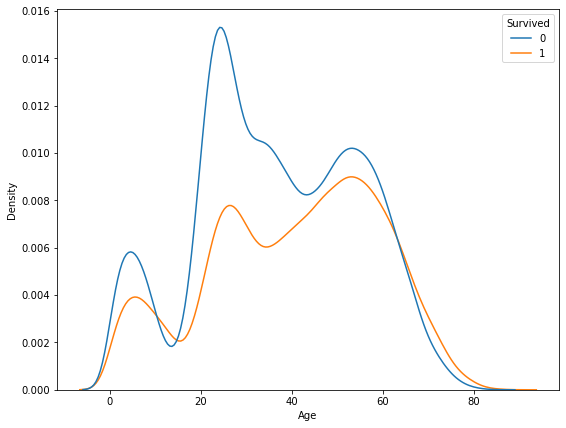

In [43]:
sns.kdeplot(x = data['Age'],hue = data['Survived']);

Young people and adults (20-40 years old) as well as children were less likely to survive. That assumption is supported by difference in mean and median ages - people who survived were usually a bit older.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

57.98% passengers of 1-st class survived
52.5% passengers of 2-nd class survived
24.73% passengers of 3-rd class survived


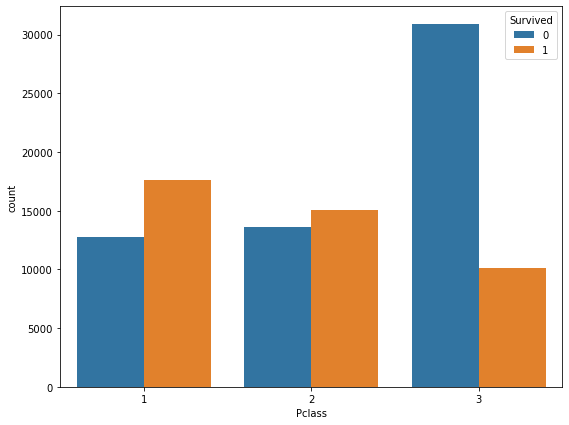

In [44]:
sns.countplot(x=data['Pclass'],hue=data['Survived'])
first_survived = data[(data['Pclass'] == 1) & (data['Survived'] == 1)].shape[0]/data[(data['Pclass'] == 1)].shape[0]*100
second_survived = data[(data['Pclass'] == 2) & (data['Survived'] == 1)].shape[0]/data[(data['Pclass'] == 2)].shape[0]*100
third_survived = data[(data['Pclass'] == 3) & (data['Survived'] == 1)].shape[0]/data[(data['Pclass'] == 3)].shape[0]*100
print(f'{round(first_survived,2)}% passengers of 1-st class survived')
print(f'{round(second_survived,2)}% passengers of 2-nd class survived')
print(f'{round(third_survived,2)}% passengers of 3-rd class survived')

Majority of 3rd class did not survive the trip. About half of 1-st and 2-nd class passengers were saved. 

Class definetely matteres when it came to survival.

59.7% passengers from Queenstown survived
75.13% passengers from Cherbourg survived
31.53% passengers from Southampton survived


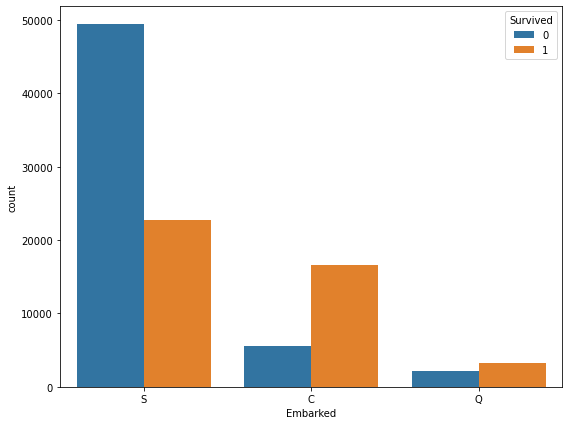

In [45]:
sns.countplot(x=data['Embarked'],hue=data['Survived'])
Q_survived = data[(data['Embarked'] == 'Q') & (data['Survived'] == 1)].shape[0]/data[(data['Embarked'] == 'Q')].shape[0]*100
C_survived = data[(data['Embarked'] == 'C') & (data['Survived'] == 1)].shape[0]/data[(data['Embarked'] == 'C')].shape[0]*100
S_survived = data[(data['Embarked'] == 'S') & (data['Survived'] == 1)].shape[0]/data[(data['Embarked'] == 'S')].shape[0]*100
print(f'{round(Q_survived,2)}% passengers from Queenstown survived')
print(f'{round(C_survived,2)}% passengers from Cherbourg survived')
print(f'{round(S_survived,2)}% passengers from Southampton survived')

Most passengers embarked in S did not survive wherear most embarked in C and Q did. Probably related to class. Most passengers embarked in Southampton were 3rd class, the other two classes mostly embarked in Queenstown and Cherbourg.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [46]:
data.isna().sum()/data.shape[0]*100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

67% values of `Cabin` missing, 3-4% of `Age` and `Ticket` missing, some missed values in `Fare` and `Embarked`.

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We can either drop the rows that contain NANs or try to fill them.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

#### Preparations

1. Drop `Ticket` ,`Name` columns
2. Derive `has_cabin` from `Cabin`
3. Drop `Cabin`
4. Fill `Age` with mean among class and sex
5. Fill `Embarked` with mode ('S')
6. Fill `Fare` with median per class
7. Combine `SibSP` and `Parch` in `FemMem`

All reasoning can be found in my Titanic EDA from module 2 [here](https://github.com/masha-mcr/ml-intro-EDA/blob/master/Titanic_Dataset_EDA.ipynb)

In [47]:
data = pd.read_csv('train.csv').set_index('PassengerId')

data['has_cabin'] = np.where(data['Cabin'].notna(), 1, 0)
data['FemMem'] = data['SibSp'] + data['Parch']
data.drop(['Name','Ticket','Cabin','SibSp','Parch'],inplace=True,axis=1)

mean_age_per_class_sex = data.groupby(['Pclass','Sex'])['Age'].mean().tolist()
i = 0
for Pclass in [1,2,3]:
    for sex in ['female','male']:
        data.loc[(data['Age'].isna()) & (data['Pclass'] == Pclass) & (data['Sex'] == sex),'Age'] = mean_age_per_class_sex[i]
        
data.loc[data['Embarked'].isna(),'Embarked'] = 'S'
median_fare_per_class = data.groupby(['Pclass'])['Fare'].median().tolist()
for Pclass in [1,2,3]:
    data.loc[(data['Fare'].isna()) & (data['Pclass'] == Pclass),'Fare'] = median_fare_per_class[Pclass-1]

In [48]:
data.isna().sum()/data.shape[0]*100

Survived     0.0
Pclass       0.0
Sex          0.0
Age          0.0
Fare         0.0
Embarked     0.0
has_cabin    0.0
FemMem       0.0
dtype: float64

In [49]:
dummies = ['Embarked', 'Sex']
dummy_data = pd.get_dummies(data[dummies])
data = pd.concat([data, dummy_data], axis = 1)
data.drop(dummies, axis=1, inplace=True)

data.head()

,Survived,Pclass,Age,Fare,has_cabin,FemMem,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
PassengerId,,,,,,,,,,,
0,1,1,46.995091,27.14,1,2,0,0,1,0,1
1,0,3,46.995091,13.35,0,0,0,0,1,0,1
2,0,3,0.330000,71.29,0,3,0,0,1,0,1
3,0,3,19.000000,13.04,0,0,0,0,1,0,1
4,1,3,25.000000,7.76,0,0,0,0,1,0,1


#### Training

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
seed = 42
features = list(data.columns[1:])
scaler = StandardScaler()
scaler.fit(data[features])
data_scaled = scaler.transform(data[features])

X_train, X_valid, y_train, y_valid = train_test_split(data_scaled, data['Survived'], test_size=0.3, random_state=seed)

<AxesSubplot:>

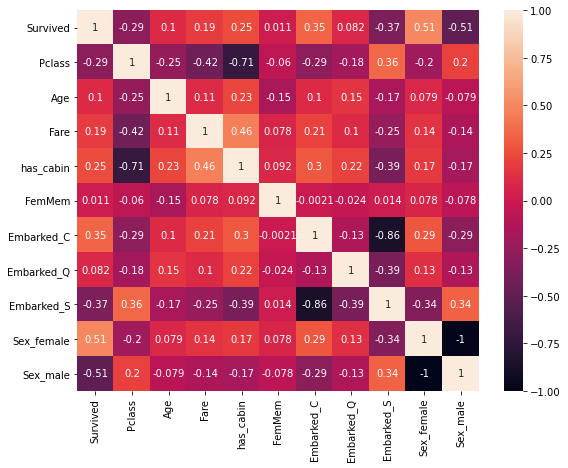

In [52]:
sns.heatmap(data.corr(),annot=True)

#### Logistic Regression

In [53]:
results = cross_validate(LogisticRegression(), 
                             data_scaled, data['Survived'], cv=5,
                             return_train_score=True,
                             scoring='accuracy')
print(np.mean(results['train_score']))
print(np.mean(results['test_score']))

0.766865
0.7670600000000001


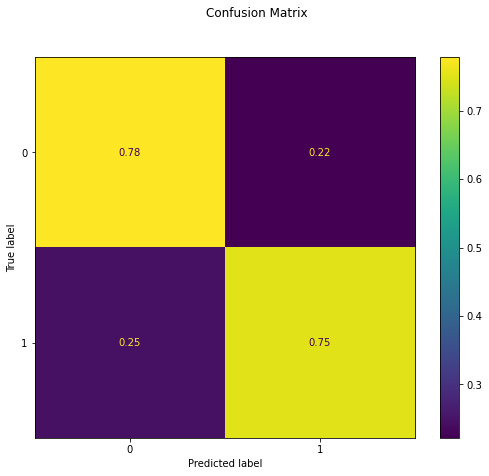

(0.7664285714285715, 0.7677)

In [54]:
fit_evaluate(LogisticRegression(), X_train, y_train, X_valid, y_valid)

#### KNN

In [ ]:
acc_train, acc_valid = [], []
for k in [1,3,5,7]:
    results = cross_validate(KNeighborsClassifier(n_neighbors=k), 
                             data_scaled, data['Survived'], cv=5,
                             return_train_score=True,
                             scoring='accuracy')
    acc_train.append(np.mean(results['train_score']))
    acc_valid.append(np.mean(results['test_score']))
print(acc_train)
print(acc_valid)

Highest result i got was 0.7677 with Logistic Regression after some feature engineering.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).


Here I tried some feature engineering, getting dummy variables, even Recursive Feature Elimination, nothing really improved my result.

**Could not submit to Kaggle, had troubles with .csv file and 10 minuted till the deadline, sorry!**

In [ ]:
new_data = data.copy()

new_data['FareCategory'] = np.nan
for quantile in range(15):
    new_data.loc[new_data['Fare'] >= new_data['Fare'].quantile(quantile/15),'FareCategory'] = quantile + 1

new_data['FareCategory'] = new_data['FareCategory'].astype(int)

new_data['travel_alone'] = np.where(new_data['FemMem']==0, 1, 0)

dummies = ['Pclass']
dummy_data = pd.get_dummies(new_data[dummies])
new_data = pd.concat([new_data, dummy_data], axis = 1)
new_data.drop(dummies, axis=1, inplace=True)

new_data.head()

In [ ]:
features=new_data.columns[1:]

from sklearn.feature_selection import RFE
model = LogisticRegression()
X_train, X_valid, y_train, y_valid = train_test_split(new_data[features], new_data['Survived'], test_size=0.3, random_state=seed)

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaler.fit(X_valid)
X_valid_scaled = scaler.transform(X_valid)

rfe = RFE(model, n_features_to_select=8)
rfe = rfe.fit(X_train_scaled, y_train)
features = np.array(features)[rfe.support_]
print(features)

In [ ]:
model = LogisticRegression()
model.fit(X_train[features],y_train)
pred_valid = model.predict(X_valid[features])
pred_train = model.predict(X_train[features])
model.score(X_valid[features],y_valid)

In [ ]:
fit_evaluate(LogisticRegression(), X_train[features], y_train, X_valid[features], y_valid)

In [ ]:
d1 = {'Survived': pred_valid}
output1 = pd.DataFrame(data=d1, index=X_valid.index)
d2 = {'Survived': pred_train}
output2 = pd.DataFrame(data=d2, index=X_train.index)
output = pd.concat([output1,output2])
print(output.head())
output.to_csv('out.csv', index=True)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.